In [1]:
import sys, os
sys.path.append("C:\\Program Files\\Lumerical\\v231\\api\\python\\")
import lumapi
# sys.path.append(os.path.dirname(__file__))
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import photonflux
import pickle
deltaP = 1e-3
um = 1e-6

# TiN Silicon Thermal Phase Shifter

In [2]:
def TiN_silicon_thermal_phase_shifter(
    waveguide_width = 0.5*um,
    heater_width = 0.5*um,
    hide = True,
    save = False,
    ):
    dev1 = lumapi.DEVICE(filename="base_TiN_heater.ldev",hide=hide)
    #Run sim with added heat
    dev1.switchtolayout()

    dev1.select("geometry::wire")
    dev1.set("x span",heater_width)

    dev1.select("geometry::wg")
    dev1.set("x span",waveguide_width)

    dev1.select("HEAT::uniform heat")
    dev1.set("total power",deltaP)

    dev1.run("HEAT")
    dev1.switchtolayout()
    if save == True:
        dev1.save("base_TiN_heater.ldev")
    dev1.close()

    mode1 = lumapi.MODE(filename="base_TiN_heater.lms",hide=hide)
    mode1.switchtolayout()

    mode1.select("wg")
    mode1.set("x span",waveguide_width)

    mode1.select('temperature')
    mode1.importdataset("T.mat")

    mode1.setnamed('temperature','enabled',0)
    mode1.setanalysis('wavelength',1.55e-6)
    mode1.findmodes()
    mode1.selectmode(1)
    neff0 = mode1.getdata("FDE::data::mode1","neff")
    mode1.switchtolayout()
    mode1.setnamed('temperature','enabled',1)
    mode1.findmodes()
    mode1.selectmode(1)
    neff_with_heat = mode1.getdata("FDE::data::mode1","neff")
    mode1.switchtolayout()
    if save == True:
        mode1.save("base_TiN_heater.lms")
    mode1.close()
    return neff_with_heat, neff0

In [3]:
waveguide_width_sweep = np.linspace(0.4*um,1.2*um,num=11)
heater_width_sweep = np.linspace(0.1*um,5.0*um,num=10)
neff_with_heat_storage = np.zeros((len(waveguide_width_sweep),len(heater_width_sweep)),dtype=complex)
neff0_storage = np.zeros((len(waveguide_width_sweep),len(heater_width_sweep)),dtype=complex)

for waveguide_width_index, waveguide_width in tqdm(enumerate(waveguide_width_sweep),desc='waveguide width sweep'):
    for heater_width_index, heater_width in enumerate(heater_width_sweep):
        neff_with_heat, neff0 = TiN_silicon_thermal_phase_shifter(waveguide_width=waveguide_width,heater_width=heater_width)
        neff_with_heat_storage[waveguide_width_index,heater_width_index] = np.squeeze(neff_with_heat)
        neff0_storage[waveguide_width_index,heater_width_index] = np.squeeze(neff0)

deltan = np.real(np.squeeze(neff_with_heat_storage - neff0_storage))
#Calculate the Ppi for this heater
L=200e-6 #200um assumed in simulation
Lambda= 1550e-9
deltaphi = 2*np.pi*deltan * L/Lambda
Ppi = deltaP * np.pi/deltaphi

storage_dict = {
    "Ppi":Ppi,
    "deltaP": deltaP,
    "Length":200e-6,
    "Lambda":1550e-9,
    "neff_with_heat":neff_with_heat_storage,
    "neff_without_heat":neff0_storage,
    "waveguide_width_sweep":waveguide_width_sweep,
    "heater_width_sweep":heater_width_sweep,
}

with open("TiN_heater_sweep.pkl",'wb') as f:
    pickle.dump(storage_dict,f)

waveguide width sweep: 11it [32:55, 179.57s/it]


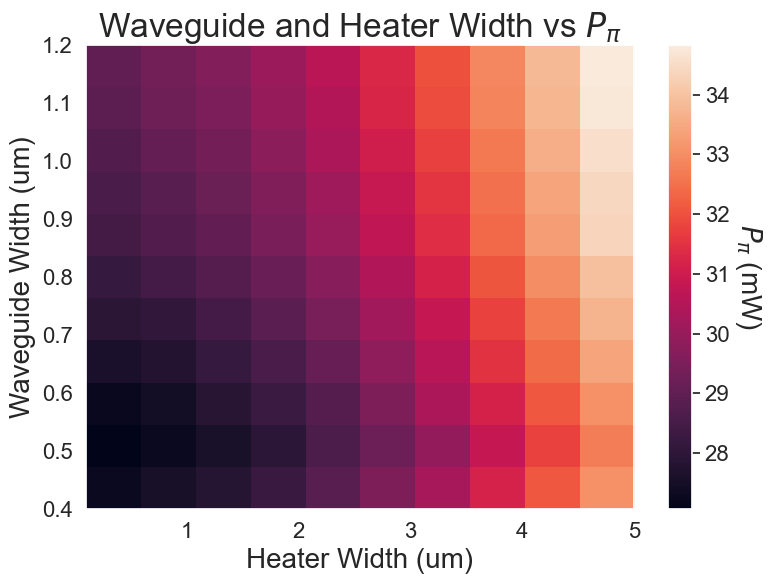

In [4]:
plt.figure(figsize=(8,6))
plt.imshow(Ppi*1e3, extent=[np.min(heater_width_sweep)*1e6,np.max(heater_width_sweep)*1e6,np.min(waveguide_width_sweep)*1e6,np.max(waveguide_width_sweep)*1e6], origin='lower', aspect='auto')
plt.xlabel("Heater Width (um)")
plt.ylabel("Waveguide Width (um)")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 25
cbar.set_label(r'$P_{\pi}$ (mW)', rotation=270)
plt.title("Waveguide and Heater Width vs " + r"$P_{\pi}$")
plt.grid(False)
plt.tight_layout()

# TiN Silicon Thermal Phase Shifter with undercut

In [5]:
dev1 = lumapi.DEVICE(filename="base_TiN_heater_undercut.ldev")
#Run sim with added heat
dev1.switchtolayout()

dev1.select("HEAT::uniform heat")
dev1.set("total power",deltaP)

dev1.run("HEAT")

dev1.close()

In [6]:
mode1 = lumapi.MODE(filename="base_TiN_heater.lms")
mode1.switchtolayout()
mode1.select('temperature')
mode1.importdataset("T.mat")

mode1.setnamed('temperature','enabled',0)
mode1.setanalysis('wavelength',1.55e-6)
mode1.findmodes()
mode1.selectmode(1)
neff0 = mode1.getdata("FDE::data::mode1","neff")
mode1.switchtolayout()
mode1.setnamed('temperature','enabled',1)
mode1.findmodes()
mode1.selectmode(1)
neff_with_heat = mode1.getdata("FDE::data::mode1","neff")
mode1.close()

In [7]:
deltan = np.real(np.squeeze(neff_with_heat - neff0))
#Calculate the Ppi for this heater
L=200e-6 #200um assumed in simulation
Lambda= 1550e-9
deltaphi = 2*np.pi*deltan * L/Lambda
Ppi = deltaP * np.pi/deltaphi
print("Ppi in milliwatts ", Ppi*1e3)

storage_dict = {
    "Ppi":Ppi,
    "length":L,
    "Lambda":Lambda,
    "neff_with_heat":neff_with_heat,
    "neff_without_heat":neff0
}
with open("TiN_heater_undercut.pkl",'wb') as f:
    pickle.dump(storage_dict,f)

Ppi in milliwatts  0.21988640556842792
